In [1]:
%matplotlib inline

In [2]:
import sys
sys.executable

'/usr/local/opt/python/bin/python3.7'

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications/InceptionV3

In [3]:
# Imports
import numpy as np 
import pandas as pd 
from glob import glob 
from skimage.io import imread 
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [4]:
# Output files
model_type='inceptionv3'
no_of_images = 1000
EPOCHS = 10
_APPEND = '_' + model_type + '_' + str(no_of_images) + '_' + str(EPOCHS)  
APPEND = _APPEND + ".png"

TRAINING_LOGS_FILE = "training_logs" + _APPEND + '.csv'
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_PLOT_FILE = "plots/model_plot_" + APPEND
MODEL_FILE = "model/model_inceptionv3_1000.h5"
TRAINING_PLOT_FILE = "training" +  APPEND
VALIDATION_PLOT_FILE = "validation" + APPEND
ROC_PLOT_FILE = "plots/roc" + APPEND

In [5]:
# Hyperparams
#SAMPLE_COUNT = 85000
#TRAINING_RATIO = 0.9
IMAGE_SIZE = 96 

BATCH_SIZE = 192
VERBOSITY = 1
TESTING_BATCH_SIZE = 100

In [6]:
SAMPLE_COUNT = 200
TRAINING_RATIO = 0.9
TESTING_BATCH_SIZE = 100
BATCH_SIZE = 10

In [7]:
# Origina data file Data (https://www.kaggle.com/c/histopathologic-cancer-detection/data)
#input_dir = '../input/'
input_dir = './dataset/'
training_dir = input_dir + 'train1000/'
data_frame = pd.DataFrame({'path': glob(os.path.join(training_dir,'*.tif'))})
data_frame.head()

,path
0,./dataset/train1000/f0c2a0b8ef3024f407fa97d852...
1,./dataset/train1000/99ef485f205645918613cd0428...
2,./dataset/train1000/e2612e173abd0e8bb54a3c3db3...
3,./dataset/train1000/6d1bb57c0606f05dbd75f90a8d...
4,./dataset/train1000/9c043ab2adadfeb758c71d2143...


In [8]:
data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[3].split('.')[0])
#data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[3])
data_frame.head()

,path,id
0,./dataset/train1000/f0c2a0b8ef3024f407fa97d852...,f0c2a0b8ef3024f407fa97d852d49be0215cafe0
1,./dataset/train1000/99ef485f205645918613cd0428...,99ef485f205645918613cd04281098daa7c17819
2,./dataset/train1000/e2612e173abd0e8bb54a3c3db3...,e2612e173abd0e8bb54a3c3db3f264b63d80bffb
3,./dataset/train1000/6d1bb57c0606f05dbd75f90a8d...,6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0
4,./dataset/train1000/9c043ab2adadfeb758c71d2143...,9c043ab2adadfeb758c71d21432fccd3e43565c0


In [9]:
labels = pd.read_csv(input_dir + 'train_labels.csv')
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [10]:
data_frame = data_frame.merge(labels, on='id')
print(data_frame.count(axis=0))
negatives = data_frame[data_frame.label == 0].sample(SAMPLE_COUNT)
positives = data_frame[data_frame.label == 1].sample(SAMPLE_COUNT)
data_frame = pd.concat([negatives, positives]).reset_index()
data_frame = data_frame[['path', 'id', 'label']]
data_frame['image'] = data_frame['path'].map(imread)

path     1000
id       1000
label    1000
dtype: int64


In [11]:
data_frame.head()

,path,id,label,image
0,./dataset/train1000/575531bd1b78c5bd734f10e1e4...,575531bd1b78c5bd734f10e1e40e3e0781dbecec,0,"[[[172, 96, 171], [181, 102, 185], [194, 111, ..."
1,./dataset/train1000/0cda9eac4409be483df65415f3...,0cda9eac4409be483df65415f370131f629c20a0,0,"[[[255, 167, 254], [198, 100, 183], [201, 100,..."
2,./dataset/train1000/390fdc7a41e5c34230c8f319f7...,390fdc7a41e5c34230c8f319f7e0296e7a849718,0,"[[[153, 96, 177], [125, 72, 154], [206, 159, 2..."
3,./dataset/train1000/de577ced57bd202857611705d0...,de577ced57bd202857611705d0333547c3f454e0,0,"[[[137, 84, 172], [132, 79, 169], [135, 82, 17..."
4,./dataset/train1000/67098fff6abb8561a4ff65ed69...,67098fff6abb8561a4ff65ed69c76418af8e9adc,0,"[[[155, 112, 184], [109, 65, 124], [117, 75, 1..."


In [12]:
training_path = './training1000'
validation_path = './validation1000'


In [13]:
for folder in [training_path, validation_path]:
    for subfolder in ['0', '1']:
        path = os.path.join(folder, subfolder)
        #os.makedirs(path, exist_ok=True)
        print('path exists? ' + path + ":" + str(os.path.exists(path)))
        if not os.path.exists(path):
            print('Creating dirs: ' + path)
            os.makedirs(path)

path exists? ./training1000/0:True
path exists? ./training1000/1:True
path exists? ./validation1000/0:True
path exists? ./validation1000/1:True


In [14]:
training, validation = train_test_split(data_frame, train_size=TRAINING_RATIO, stratify=data_frame['label'])

data_frame.set_index('id', inplace=True)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [15]:
for images_and_path in [(training, training_path), (validation, validation_path)]:
    images = images_and_path[0]
    path = images_and_path[1]
    if not os.path.exists(path):
        for image in images['id'].values:
            file_name = image + '.tif'
            label = str(data_frame.loc[image,'label'])
            destination = os.path.join(path, label, file_name)
            print(destination + ': os.path.exists?' + str(os.path.exists(destination)))
            if not os.path.exists(destination):
                source = os.path.join(input_dir + 'train1000', file_name)
                shutil.copyfile(source, destination)
    else:
        print(path + ' already exists')

./training1000 already exists
./validation1000 already exists


In [16]:
# Data augmentation
training_data_generator = ImageDataGenerator(rescale=1./255,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             rotation_range=180,
                                             zoom_range=0.4, 
                                             width_shift_range=0.3,
                                             height_shift_range=0.3,
                                             shear_range=0.3,
                                             channel_shift_range=0.3)

In [17]:
# Data generation
training_generator = training_data_generator.flow_from_directory(training_path,
                                                                 target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                 batch_size=BATCH_SIZE,
                                                                 class_mode='binary')
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                              target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                              batch_size=BATCH_SIZE,
                                                                              class_mode='binary')
testing_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                           target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                           batch_size=BATCH_SIZE,
                                                                           class_mode='binary',
                                                                           shuffle=False)

Found 874 images belonging to 2 classes.
Found 185 images belonging to 2 classes.
Found 185 images belonging to 2 classes.


In [18]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


87916544/87910968 [==============================] - 52s 1us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


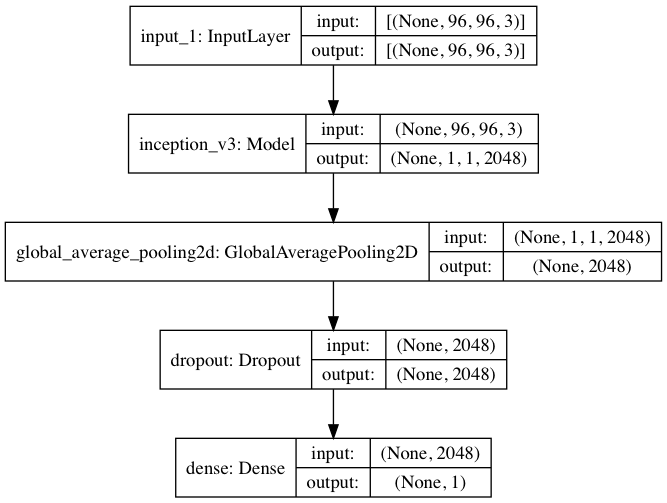

In [19]:
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

#xception = Xception(include_top=False, input_shape=input_shape)(inputs)
inception_v3 = InceptionV3(include_top=False, input_shape=input_shape)(inputs)

outputs = GlobalAveragePooling2D()(inception_v3)
outputs = Dropout(0.5)(outputs)
outputs = Dense(1, activation='sigmoid')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

plot_model(model,
           to_file=MODEL_PLOT_FILE,
           show_shapes=True,
           show_layer_names=True)

In [20]:
#  Training
history = model.fit_generator(training_generator,
                              steps_per_epoch=len(training_generator), 
                              validation_data=validation_generator,
                              validation_steps=len(validation_generator),
                              epochs=EPOCHS,
                              verbose=VERBOSITY,
                              callbacks=[#PlotLossesKeras(),
                                         ModelCheckpoint(MODEL_FILE,
                                                         monitor='val_accuracy',
                                                         verbose=VERBOSITY,
                                                         save_best_only=True,
                                                         mode='max'),
                                         CSVLogger(TRAINING_LOGS_FILE,
                                                   append=True,
                                                   separator=';')
                              ])

Epoch 1/10


W0817 16:17:07.823709 140736160445312 deprecation.py:323] From /Users/rdua/Library/Python/3.7/lib/python/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


87/88 [============================>.] - ETA: 2s - loss: 0.7017 - accuracy: 0.5833
Epoch 00001: val_accuracy improved from -inf to 0.62703, saving model to model/model_inceptionv3_1000.h5
88/88 [==============================] - 237s 3s/step - loss: 0.7029 - accuracy: 0.5812 - val_loss: 0.7185 - val_accuracy: 0.6270
Epoch 2/10
87/88 [============================>.] - ETA: 0s - loss: 0.6478 - accuracy: 0.6447
Epoch 00002: val_accuracy improved from 0.62703 to 0.65946, saving model to model/model_inceptionv3_1000.h5
88/88 [==============================] - 82s 929ms/step - loss: 0.6476 - accuracy: 0.6465 - val_loss: 0.7836 - val_accuracy: 0.6595
Epoch 3/10
87/88 [============================>.] - ETA: 0s - loss: 0.6235 - accuracy: 0.6887
Epoch 00003: val_accuracy improved from 0.65946 to 0.70811, saving model to model/model_inceptionv3_1000.h5
88/88 [==============================] - 86s 982ms/step - loss: 0.6214 - accuracy: 0.6911 - val_loss: 0.5470 - val_accuracy: 0.7081
Epoch 4/10
87/

In [21]:
history.history

{'loss': [0.7054001386160164,
  0.6497240064482395,
  0.6169239839781886,
  0.6363812822430849,
  0.5698406142896592,
  0.5841108832670294,
  0.5603480720615496,
  0.5764401501185289,
  0.545414591783517,
  0.5166418291202126],
 'accuracy': [0.5812357,
  0.6464531,
  0.6910755,
  0.69679636,
  0.7139588,
  0.70251715,
  0.7368421,
  0.715103,
  0.75743705,
  0.7597254],
 'val_loss': [0.7184597614564394,
  0.7835954584573445,
  0.5469922391991866,
  0.5218801419985922,
  0.550739093830711,
  0.5105459878319188,
  0.42451693901890203,
  0.5373571922904566,
  0.5496227458903664,
  0.45087579833833796],
 'val_accuracy': [0.62702703,
  0.6594595,
  0.7081081,
  0.76216215,
  0.7837838,
  0.7675676,
  0.78918916,
  0.74594593,
  0.78918916,
  0.81621623]}

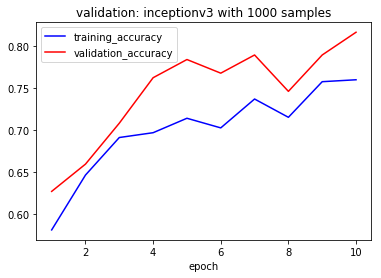

In [26]:
# Training plots
common_title = model_type + ' with ' + str(no_of_images) + ' samples'
epochs = [i for i in range(1, len(history.history['loss'])+1)]

plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
plt.title('training: ' + common_title)
plt.xlabel('epoch')
plt.savefig(TRAINING_PLOT_FILE, bbox_inches='tight')
plt.close()

plt.plot(epochs, history.history['accuracy'], color='blue', label="training_accuracy")
plt.plot(epochs, history.history['val_accuracy'], color='red',label="validation_accuracy")
plt.legend(loc='best')
plt.title('validation: ' + common_title)
plt.xlabel('epoch')
plt.savefig(VALIDATION_PLOT_FILE, bbox_inches='tight')
plt.show()
plt.close()

19/19 [==============================] - 1s 55ms/step


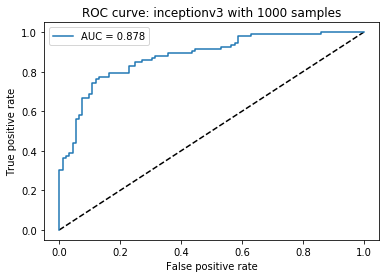

In [27]:
# ROC testing plot
#model.load_weights(MODEL_FILE)
predictions = model.predict_generator(testing_generator, steps=len(testing_generator), verbose=VERBOSITY)
false_positive_rate, true_positive_rate, threshold = roc_curve(testing_generator.classes, predictions)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve: ' + common_title)
plt.legend(loc='best')
plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.show()
plt.close()